# bike model results

In [216]:
import h5py
import pandas as pd
import pylab as P
from IPython.display import display, display_pretty, Javascript, HTML
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
# Show charts in notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## destination

In [217]:
# Load daysim outputs results
model = h5py.File(r'D:\soundcast\soundcast\outputs\daysim_outputs.h5')

In [218]:
# Load survey data
survey = h5py.File(r'D:\soundcast\soundcast\scripts\summarize\inputs\calibration\survey.h5')

In [219]:
def get_df(h5file, table, fields, nested=False):
    '''return all fields from h5 table'''
    data = {}
    for field in fields:
        if nested:
            data[field] = [i[0] for i in h5file[table][field][:]]
        else:   
            data[field] = [i for i in h5file[table][field][:]]
        
    return pd.DataFrame(data)

In [220]:
# List of columns we want to import
trip_fields = ['dorp','dtaz','otaz','opurp','mode','dpcl','opcl','arrtm','deptm']

In [221]:
survey_trip = get_df(h5file=survey, table='Trip', fields=trip_fields + ['trexpfac'], nested=True)
survey_bike_trips = survey_trip[survey_trip['mode'] == 2]

In [222]:
model_trip = get_df(h5file=model, table='Trip', fields=trip_fields, nested=False)
model_bike_trips = model_trip[model_trip['mode'] == 2]

In [223]:
# join parcel data to geography
taz_lookup = pd.read_csv(r'D:\soundcast\soundcast\scripts\summarize\inputs\parcels_in_urbcens.csv')

In [224]:
district_lookup = pd.read_csv(r'D:\soundcast\soundcast\scripts\summarize\inputs\calibration\TAZ_TAD_County.csv')

In [225]:
def join_od_rgc(df,taz_lookup):
    '''Join RGC name based on trip destination and origin parcels'''
    
    # By trip destination parcel
    df = df.merge(taz_lookup, left_on='dpcl', right_on='hhparcel')
    df['d_rgc'] = df['NAME']
    
    # By trip origin parcel
    df.drop('NAME', 1, inplace=True)
    df = df.merge(taz_lookup, left_on='opcl', right_on='hhparcel')
    df['o_rgc'] = df['NAME']
    
    return df

In [226]:
# survey_bike_trips = join_od_rgc(df=survey_bike_trips, taz_lookup=taz_lookup)
# model_bike_trips = join_od_rgc(df=model_bike_trips, taz_lookup=taz_lookup)

In [227]:
dest_survey_bike_trips = survey_bike_trips.merge(district_lookup,left_on='dtaz',right_on='TAZ')
orig_survey_bike_trips = survey_bike_trips.merge(district_lookup,left_on='otaz',right_on='TAZ')

dest_model_bike_trips = model_bike_trips.merge(district_lookup,left_on='dtaz',right_on='TAZ')
orig_model_bike_trips = model_bike_trips.merge(district_lookup,left_on='otaz',right_on='TAZ')

In [228]:
# Set some formatting options
pd.options.display.float_format = '{:.1f}%'.format    # set float format as percent, until further notic

## Bike Trip Destinations (County)

In [229]:
srv = dest_survey_bike_trips
mdl = dest_model_bike_trips
srv_name = '2006 Survey'
mdl_name = '2010 Model'

df = pd.DataFrame({srv_name: (srv.groupby('County').sum()['trexpfac']/srv.groupby('County').sum()['trexpfac'].sum())*100,
              mdl_name: (mdl.groupby('County').count()['TAZ']/mdl.groupby('County').count()['TAZ'].sum())*100})
df

,2006 Survey,2010 Model
County,,
King,68.1%,57.4%
Kitsap,10.0%,5.6%
Pierce,8.5%,20.3%
Snohomish,13.3%,16.8%


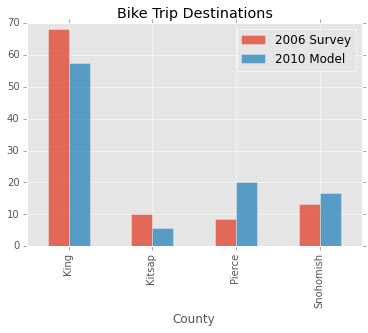

In [230]:
df[[srv_name,mdl_name]].plot(kind='bar', alpha=0.8, title='Bike Trip Destinations')

# Bike Trips Destinations (Districts)

In [231]:
df = pd.DataFrame({srv_name: (srv.groupby('New DistrictName').sum()['trexpfac']/srv.groupby('New DistrictName').sum()['trexpfac'].sum())*100,
              mdl_name: (mdl.groupby('New DistrictName').count()['TAZ']/mdl.groupby('New DistrictName').count()['TAZ'].sum())*100})
df

,2006 Survey,2010 Model
East Side,16.0%,17.5%
Everett-Lynwood-Edmonds,5.6%,9.3%
Kitsap,10.0%,5.6%
North Seattle-Shoreline,25.7%,9.9%
Renton-FedWay-Kent,8.6%,15.0%
S.Kitsap,nan%,0.6%
Seattle CBD,11.8%,9.6%
South Pierce,4.9%,10.3%
Suburban Snohomish,7.8%,7.5%
Tacoma,3.6%,9.4%


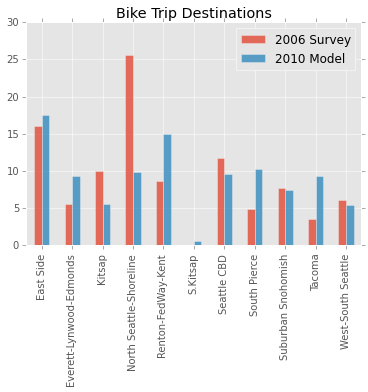

In [232]:
df[[srv_name,mdl_name]].plot(kind='bar', alpha=0.8, title='Bike Trip Destinations')

# Screenlines

In [274]:
pd.reset_option('float_format')

In [275]:
df = pd.read_csv(r'D:\soundcast\soundcast\outputs\bike_volumes.csv')

In [276]:
df = df.groupby(['EmmeINode','EmmeJNode']).mean()

In [277]:
# AM counts correspond to 7 to 9 AM for WSDOT data
df['AM'] = df['bvol7to8']+df['bvol8to9']

In [278]:
# Associate each link with a counter location
counts_intersect = pd.read_csv(r'R:\Bike\Counts\counts_intersect.csv')

In [279]:
am_counts = counts_intersect[counts_intersect['CountTime'] == 'AM']
total_am_bike_counts = am_counts.groupby('OBJECTID').sum()['Bike_Total']

In [280]:
df = am_counts.merge(df,left_on=['INode','JNode'],right_on=['gdbINode','gdbeJNode'])

In [281]:
am_total = pd.DataFrame(df.groupby('OBJECTID').sum()['AM'])
am_total['OBJECTID'] = am_total.index

In [282]:
# Seattle only
# Cmment this out for regional results
am_counts = am_counts[am_counts['CityName'] == 'Seattle']

In [283]:
am_total = am_total.merge(am_counts[['OBJECTID','LocationDe','CountDate','Latitude','Longitude','Bike_Total']],on='OBJECTID')
df = am_total.groupby('LocationDe').mean()[['AM','Bike_Total']]
df.columns = ['Model','Observed']

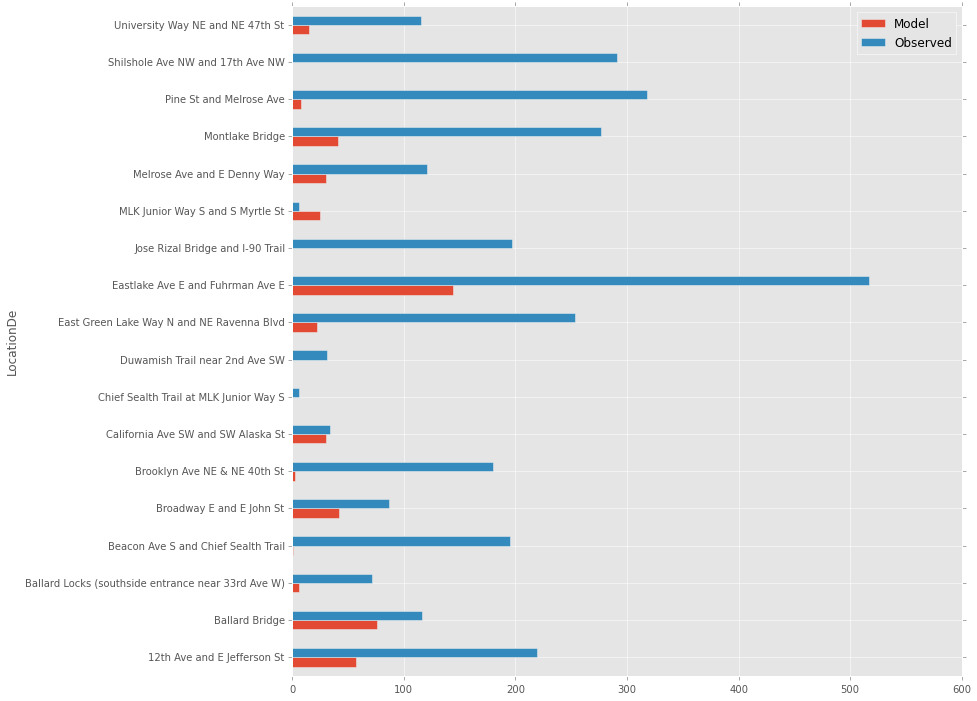

In [284]:
df.plot(kind='barh',figsize=(12,12))

# Destinations by Zone

In [242]:
# Sum all trips by destination zone and fill zones with zero trips
# survey trips first

#### uncomment to show trips by all modes, otherwise, showing bike trips only
# srv = survey_trip
# mdl = model_trip

df = pd.DataFrame(srv.groupby('dtaz').sum()['trexpfac'])
df['taz'] = df.index

# empty df to act as base for merging trip totals by destination zone
empty = pd.DataFrame(np.zeros(3700),columns=['taz'])
empty['taz']=[i+1 for i in empty.index]
df = empty.merge(df,on='taz', how='left')
df.fillna(0,inplace=True)
df[srv_name] = df['trexpfac']
df = df[['taz',srv_name]]

# Add model trips to this df
mdl_df = pd.DataFrame(mdl.groupby('dtaz').count()['mode'])
mdl_df[mdl_name] = mdl_df['mode']
mdl_df['taz'] = mdl_df.index

df = df.merge(mdl_df,on='taz',how='left')[[srv_name,mdl_name,'taz']]
df.index= df['taz']
df = df[[srv_name,mdl_name]]

In [243]:
df.max()[srv_name]

2592.5500000000002

**Trip End Totals by Zone**

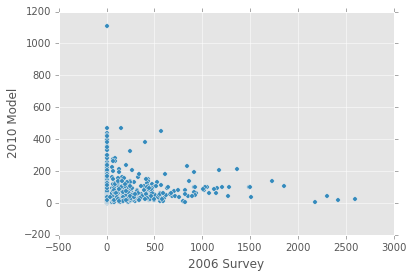

In [244]:
df.plot(kind='scatter', x=srv_name, y=mdl_name)
# df[df[srv_name]>0].plot(kind='hexbin', x=srv_name, y=mdl_name, gridsize=20)

** Distribution of Trip End Totals by Zone **

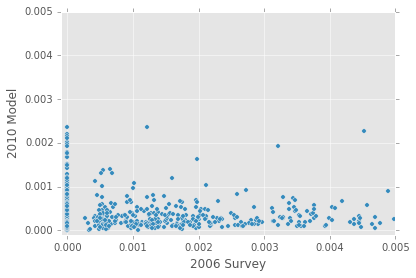

In [245]:
pd.DataFrame({mdl_name:df[mdl_name]/df[mdl_name].sum(),
             srv_name:df[srv_name]/df[srv_name].sum()}).plot(kind='scatter', x=srv_name, y=mdl_name,
                                                            xlim=[-.0001,0.005],ylim=[-0.0001,0.005])


## Heatmap

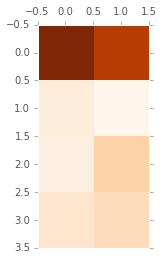

In [246]:
df = pd.DataFrame({srv_name: (srv.groupby('County').sum()['trexpfac']/srv.groupby('County').sum()['trexpfac'].sum())*100,
              mdl_name: (mdl.groupby('County').count()['TAZ']/mdl.groupby('County').count()['TAZ'].sum())*100})
df

ax = plt.imshow(df, interpolation='nearest', cmap='Oranges').axes
ax.grid('off')
ax.xaxis.tick_top()

In [247]:
len(df)

4

In [248]:
df.fillna(0,inplace=True)

## Skim Results

In [249]:
# Load skim data
h5data = h5py.File(r'D:\soundcast\soundcast\inputs\7to8.h5')
perceived = pd.DataFrame(h5data['Skims']['mfbkpt'][:])
actual = pd.DataFrame(h5data['Skims']['mfbkat'][:])

In [250]:
# Get the TAZ lookup dict
tazlookup = pd.read_csv(r'D:\soundcast\soundcast\scripts\summarize\inputs\calibration\TAZ_TAD_County.csv')

In [251]:
tazlookup;

In [252]:
# Extract link values and compare to counts

# Daily Counts

In [67]:
def daily_count_sum(location, year, month):
    df = pd.read_csv(r'R:\Bike\Bike count Data\seattle counters\data\\'+location+'.csv')
    df['datetime'] = pd.to_datetime(df['Date'])
    df['weekday_value'] = df['datetime'].apply(lambda row: row.weekday())
    df['month'] = df['datetime'].apply(lambda row: row.month)
    df['year'] = df['datetime'].apply(lambda row: row.year)
    df['day'] = df['datetime'].apply(lambda row: row.day)

    # Get all spring months, march through may
    df = df[df['month'].isin([3,4,5])]

    # Get only weekdays
    df = df[df['weekday_value'].isin([0,1,2,3,4])]

    # Get daily totals
    df = df[df['year'].isin([2014])]
    
    # Average daily total for time period
    return df.groupby(['month','day']).sum().mean()

In [68]:
df = daily_count_sum(location='burke',year=[2014],month=[3,4,5])
df

BGT North of NE 70th Total     1497.507692
Ped South                       195.538462
Ped North                       180.353846
Bike North                      548.030769
Bike South                      573.584615
weekday_value                    48.000000
year                          48336.000000
dtype: float64

In [69]:
df = daily_count_sum(location='fremont',year=[2014],month=[3,4,5])
df

Fremont Bridge West Sidewalk     1806.584615
Fremont Bridge East Sidewalk     1718.846154
weekday_value                      48.000000
year                            48336.000000
dtype: float64

In [70]:
df = daily_count_sum(location='spokane',year=[2014],month=[3,4,5])
df

Spokane St. Bridge Total      991.107692
West                          482.261538
East                          508.846154
weekday_value                  48.000000
year                        48336.000000
dtype: float64

In [71]:
df = daily_count_sum(location='26sw_greenway',year=[2014],month=[3,4,5])
df

26th Ave SW Greenway at SW Oregon St Total      602.276923
North                                           125.061538
South                                           477.215385
weekday_value                                    48.000000
year                                          48336.000000
dtype: float64

In [72]:
df = daily_count_sum(location='elliot_bay_trail',year=[2014],month=[3,4,5])
df

Elliott Bay Trail in Myrtle Edwards Park Total     3782.338462
Ped North                                          1283.661538
Ped South                                          1140.276923
Bike North                                          731.538462
Bike South                                          626.861538
weekday_value                                        48.000000
year                                              48336.000000
dtype: float64